In [1]:
import lfx
import flax.nnx as nnx
import flax
import jax
import jax.numpy as jnp
import numpy as np
from jax_autovmap import auto_vmap

import matplotlib.pyplot as plt
import flax.typing as ftp
from functools import partial
import typing as tp

# Free theory

In [2]:
mass = 0.5
lat_shape = (32, 32)

# constructing scaling explicitly here;
# note there is also lfx.FreeTheoryScaling (see MCMC section below)
ks = lfx.fft_momenta(lat_shape, lattice=True)
spectrum = 1 / (mass**2 + jnp.sum(ks**2, axis=-1))

# note: specturm here could also be a nnx.Param to make it trainable;
# or set it to output of (trainable) function of ks
scaling = lfx.SpectrumScaling(spectrum)

free_theory_prior = lfx.Sampler(
    lfx.IndependentNormal(lat_shape, rngs=nnx.Rngs(sample=0)),
    scaling
)

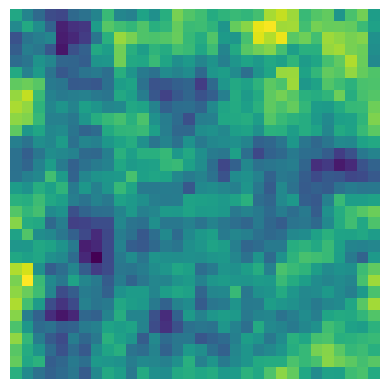

In [3]:
x, _ = free_theory_prior.sample()
plt.imshow(x)
plt.axis('off')
plt.show()

# Phi4

In [4]:
# "build" provides a constructor similar to the jaxnf version

rngs = nnx.Rngs(params=0)
vf = lfx.Phi4CNF.build((32, 32), (), rngs=rngs)

## Transfer model parameters from previous version

In [5]:
# convolution conventions change between frameworks, need to relabel orbits
import jaxnf

def reshuffle_orbits(kernel_params, kernel_shape):
    oc, old_orbits = jaxnf.lattice.conv_utils.kernel_d4(kernel_shape)
    kernel = jaxnf.lattice.conv_utils.unfold_kernel(kernel_params, old_orbits)
    for d, s in enumerate(kernel.shape[:-2]):
        kernel = jnp.roll(kernel, -1 + (s % 2), axis=d)
    return lfx.conv.fold_kernel(kernel, vf.conv.orbits, oc)

In [6]:
# transfer jaxnf -> this

# setup and get jaxnf parameters for demonstration
jaxnf_vf = jaxnf.lattice.Phi4CNF((32, 32))
params_jxnf = jaxnf_vf.init(
    rngs.params(), 0.1, (jnp.zeros((32, 32, 1)), 0.0))['params']

params_jxnf = jax.tree.map(lambda p: p + np.random.normal(size=p.shape), params_jxnf)

# transfer parameters
_, params = nnx.split(vf)

params.replace_by_pure_dict({
    'conv': {'kernel_params': reshuffle_orbits(params_jxnf['kernel'], (32, 32))},
    'feature_map': {'features': {0: params_jxnf['features_0']}},
    'feature_superposition': params_jxnf['freq_superpos'],
    'time_kernel': {'superposition': params_jxnf['time_superpos']}
})

# in place update
nnx.update(vf, params)

In [7]:
# transfer haiku -> this
params_haiku = np.load('../jax-flows/share-pullback/all-parameters/single-L32.npz', allow_pickle=True)['params'].item()

_, params = nnx.split(vf)

params.replace_by_pure_dict({
    'conv': {'kernel_params': reshuffle_orbits(params_haiku['~']['w'], (32, 32))},
    'feature_map': {'features': {0: {'phi_freq': params_haiku['~']['phi_freq'][None]}}},
    'feature_superposition': params_haiku['~']['freq_superpos'],
    'time_kernel': {'superposition': params_haiku['~']['time_superpos']}
})

# in place update
nnx.update(vf, params)

## Sampling

In [8]:
flow = lfx.ContFlowRK4(vf, dt=1/50)
sampler = lfx.Sampler(
    lfx.IndependentNormal((32, 32), rngs=nnx.Rngs(sample=0)),
    flow,
)

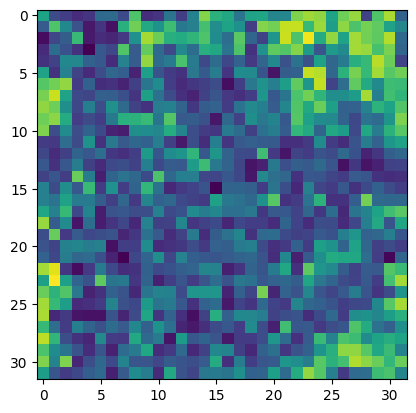

In [9]:
x, _ = sampler.sample(())
plt.imshow(x)
plt.show()

# Fourier components

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

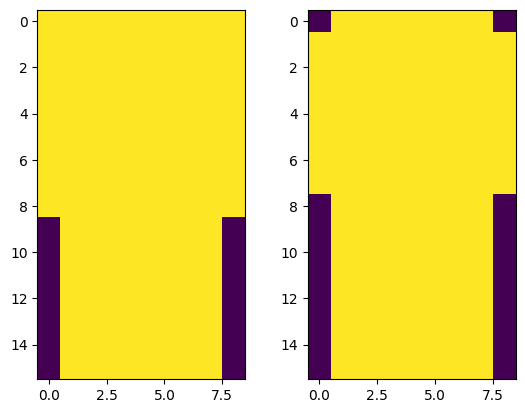

In [11]:
# these mask out independent "real" degrees of freedom from rfftn
rm, im = lfx.fourier.get_fourier_masks((16, 16))
plt.subplot(121)
plt.imshow(rm)
plt.subplot(122)
plt.imshow(im)
plt.show()

# MCMC sampling

In [12]:
rngs = nnx.Rngs(43)

In [13]:
# start again with the free theory
mass = 0.5
lat_shape = (32, 32)

sampler = lfx.Sampler(
    lfx.IndependentNormal(lat_shape, rngs=nnx.Rngs(sample=0)),
    lfx.FreeTheoryScaling(mass**2, lat_shape, half=False)
)

In [14]:
# define our phi4 theory

@flax.struct.dataclass
class Phi4Theory:
    m2: float = -4
    lam: float = 5.0

    @auto_vmap(None, 2)
    def action(self, phi):
        act = lfx.scalartheory.phi4_term(phi, self.m2, self.lam)
        return jnp.sum(act) # / 2

    def log_prob(self, phi):
        return -self.action(phi)

In [15]:
@jax.jit
def imh_step(rng, state, mass, lam):
    target = Phi4Theory(m2=mass**2, lam=lam)
    imh = lfx.sampling.IMH(sampler.sample, target.log_prob)
    return imh.step(rng, state)

@jax.jit
def imh_init(rng, mass, lam):
    target = Phi4Theory(m2=mass**2, lam=lam)
    imh = lfx.sampling.IMH(sampler.sample, target.log_prob)
    return imh.init(rng)

In [20]:
lams = np.linspace(0, 0.5, 8)
accept_rate = np.zeros(len(lams))

for i, lam in enumerate(lams):
    count = 5000
    accepted = 0

    state = imh_init(rngs(), mass, lam)

    for _ in range(count):
        state, info = imh_step(rngs(), state, mass, lam)
        accepted += info.is_accepted
    accept_rate[i] = accepted / count

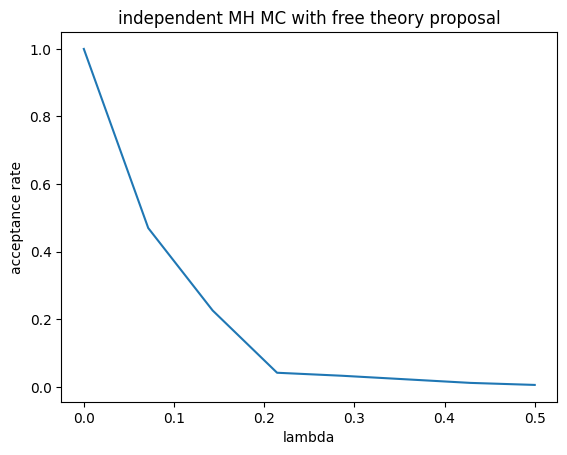

In [21]:
plt.title('independent MH MC with free theory proposal')
plt.plot(lams, accept_rate)
plt.xlabel('lambda')
plt.ylabel('acceptance rate')
plt.show()